<a href="https://colab.research.google.com/github/tomasplsek/AstroML/blob/main/03_sklearn_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. hands-on session: **From *Data* to *Prediction***

## **Contents**

1. Preprocess the data
1. Select features & reduce dimensions
1. Cross-validate
1. Find best hyperparameters
1. Compare classifiers
1. Combine classifiers
1. Evaluate performance
1. Predict

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Our dataset**

SDSS photometry of points sources: Star vs QSO

<img src="https://cdn.mos.cms.futurecdn.net/HgaCHZDNppE6e52yeDACo6-970-80.jpg.webp" width=500 align=left>

<img src="https://earthsky.org/upl/2021/01/supermassive-black-hole-artist-e1610556964639.jpg" width=500 align=right>



### **Sloan Digital Sky Survey (SDSS)**

- photometry & spectroscopy

- fotometry 1 billion objects

- spectroscopy 6 million objects

- **stars** from our Galaxy  &  **quasars** up to $z \approx 6$

- color system `u g r i z`

<img src="https://www.astroml.org/_images/fig_sdss_filters_1.png" align=left width=500>

In [2]:
!wget -c "https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB" -O "sdss_photo.csv"

--2023-10-17 13:41:55--  https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving drive.google.com (drive.google.com)... 142.251.37.110, 2a00:1450:4014:80f::200e
Connecting to drive.google.com (drive.google.com)|142.251.37.110|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



## **Data preprocessing**

In [3]:
data = pd.read_csv("sdss_photo.csv")

In [4]:
data

,u,g,r,i,z,target
0,19.240999,17.525999,16.840000,16.613001,16.492001,star
1,19.732000,18.339001,17.767000,17.580000,17.481001,star
2,16.120001,15.232000,14.933000,14.845000,14.827000,star
3,18.995001,18.150999,17.877001,17.747000,17.766001,star
4,19.032000,18.112000,17.848000,17.709999,17.712000,star
...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,QSO
863,26.433001,21.429001,20.261000,20.108000,20.073000,QSO
864,20.535999,20.200001,20.292999,19.910000,19.726000,QSO
865,20.627001,20.583000,20.270000,20.229000,20.190001,QSO


In [5]:
data.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,19.29,18.17,17.72,17.54,17.45
std,1.39,1.33,1.35,1.37,1.38
min,15.67,14.36,14.12,13.95,13.89
25%,18.50,17.29,16.74,16.54,16.45
50%,19.33,18.33,17.88,17.69,17.62
75%,20.02,19.09,18.76,18.61,18.52
max,26.43,25.17,21.14,20.72,20.91


In [6]:
star = data.target == "star"
qso = data.target == "QSO"

sum(star), sum(qso)

(655, 212)

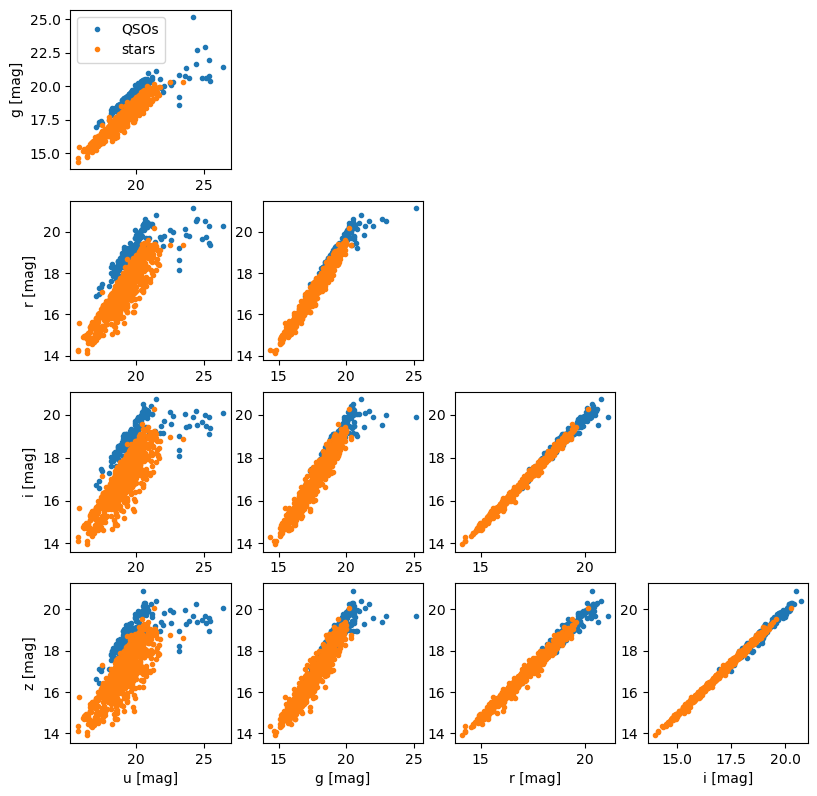

In [7]:
filters = ["u", "g", "r", "i", "z"]

plt.figure(figsize=(12,12))

x = 0
for i in range(5):
    for j in range(5):
        x += 1
        if i == j: continue
        elif i < j: continue

        f1 = filters[i]
        f2 = filters[j]

        plt.subplot(5,5,x)
        plt.plot(data.loc[qso, f2], data.loc[qso, f1], ".", label="QSOs")
        plt.plot(data.loc[star, f2], data.loc[star, f1], ".", label="stars")

        if i == 4: plt.xlabel(f2 + " [mag]")
        if j == 0: plt.ylabel(f1 + " [mag]")
        if x == 6: plt.legend()

### task 1: **create `X` and `y`**

```python
data[["u","g","r","i","z"]] -> X
data["target"] -> y
"QSO" -> 0
"star" -> 1
```

hint: you can use [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
X = data[["u","g","r","i","z"]]
X

,u,g,r,i,z
0,19.240999,17.525999,16.840000,16.613001,16.492001
1,19.732000,18.339001,17.767000,17.580000,17.481001
2,16.120001,15.232000,14.933000,14.845000,14.827000
3,18.995001,18.150999,17.877001,17.747000,17.766001
4,19.032000,18.112000,17.848000,17.709999,17.712000
...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000
863,26.433001,21.429001,20.261000,20.108000,20.073000
864,20.535999,20.200001,20.292999,19.910000,19.726000
865,20.627001,20.583000,20.270000,20.229000,20.190001


In [10]:
y = star.astype(int)
y

0      1
1      1
2      1
3      1
4      1
      ..
862    0
863    0
864    0
865    0
866    0
Name: target, Length: 867, dtype: int64

In [11]:
le = LabelEncoder()
# le.fit(data.target)
# y = le.transform(data.target)
y = le.fit_transform(data.target)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
le.inverse_transform([0,1])

array(['QSO', 'star'], dtype=object)

### task 2: **split the data (9:1), train a linear [Support Vector Classifier (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) & test its accuracy**

```python
from sklearn.svm import SVC

model = SVC(kernel="linear")
```

<img src="https://drive.google.com/uc?id=1ZyN7sykZBm0Q8xDKjMcHrezV_G91ErWH" align=left width=350>

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=120, stratify=y)

In [14]:
from sklearn.svm import SVC

model = SVC(kernel="linear")

In [15]:
model.fit(X_train, y_train)

SVC(kernel='linear')

In [16]:
y_pred = model.predict(X_test)
sum(y_pred == y_test) / len(y_pred)

0.9425287356321839

In [17]:
model.score(X_test, y_test)

0.9425287356321839

### task 3: **rescale the data -> `X_scaled` & split the data & train & test score**

note: the data were already transformed from fluxes to magnitudes `m = -log10(F/F0)`

```python
X_scaled = (X - μ) / σ
```

hint: you can use [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [18]:
X_scaled = (X - X.mean()) / X.std()
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.61,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.14,5.24,2.52,2.32,2.51


In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.03431629, -0.48472471, -0.64808566, -0.67580301, -0.69718857],
       [ 0.31930584,  0.12473607,  0.03656377,  0.03011821,  0.0203667 ],
       [-2.28207913, -2.20440421, -2.05652877, -1.9664652 , -1.90520657],
       ...,
       [ 0.89835098,  1.51982126,  1.90217729,  1.73104683,  1.64919409],
       [ 0.96389084,  1.806934  ,  1.88519118,  1.96392093,  1.98584328],
       [ 0.1025233 ,  0.79116842,  0.79506994,  0.91416343,  1.0665891 ]])

In [21]:
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9425287356321839

### **Create a pipeline**

In [23]:
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=120, stratify=y)

model = make_pipeline(StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9425287356321839

In [24]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

## **Feature selection & dimensionality reduction**

In [25]:
from sklearn.ensemble import ExtraTreesClassifier

In [26]:
etc = ExtraTreesClassifier(random_state=42)
etc.fit(X,y)
etc.feature_importances_

array([0.29715325, 0.11687197, 0.21442021, 0.19203806, 0.17951651])

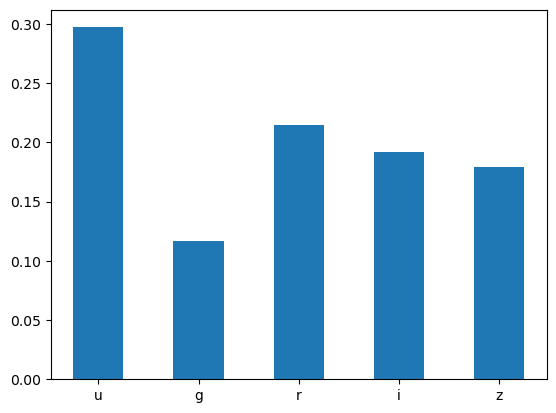

In [27]:
plt.bar(np.arange(5), etc.feature_importances_, 0.5)
plt.xticks(np.arange(5), X.columns);

#### task 4: **calculate spectral indices & test importance**


In [28]:
X["u-g"] = X.u - X.g
X["g-r"] = X.g - X.r
X["r-z"] = X.r - X.z
X["i-z"] = X.i - X.z

X

,u,g,r,i,z,u-g,g-r,r-z,i-z
0,19.240999,17.525999,16.840000,16.613001,16.492001,1.715000,0.685999,0.348000,0.121000
1,19.732000,18.339001,17.767000,17.580000,17.481001,1.393000,0.572001,0.285999,0.098999
2,16.120001,15.232000,14.933000,14.845000,14.827000,0.888000,0.299001,0.106000,0.018001
3,18.995001,18.150999,17.877001,17.747000,17.766001,0.844002,0.273998,0.111000,-0.019001
4,19.032000,18.112000,17.848000,17.709999,17.712000,0.920000,0.264000,0.136000,-0.002001
...,...,...,...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,0.199999,0.384001,-0.007999,-0.043999
863,26.433001,21.429001,20.261000,20.108000,20.073000,5.004000,1.168001,0.188000,0.035000
864,20.535999,20.200001,20.292999,19.910000,19.726000,0.335999,-0.092999,0.566999,0.184000
865,20.627001,20.583000,20.270000,20.229000,20.190001,0.044001,0.313000,0.080000,0.039000


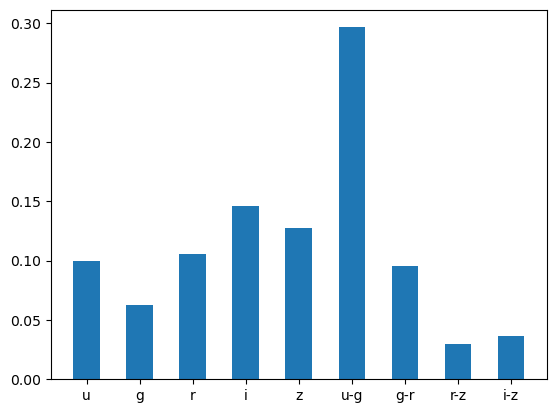

In [29]:
etc = ExtraTreesClassifier(random_state=42)
etc.fit(X,y)
plt.bar(np.arange(9), etc.feature_importances_, 0.5)
plt.xticks(np.arange(9), X.columns);

#### task 5: **test score if only *u-g* or *i-z* spectral indices are used**

hint: for single columns use `X[["u-g"]]`

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X[["u-g"]], y, test_size=0.1, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9655172413793104

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[["i-z"]], y, test_size=0.1, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7586206896551724

In [34]:
sum(star) / len(star)

0.7554786620530565

#### task 6: **create dummy column & test importance**

hint:
```
X_new = X.copy()
X_new["dummy"] = np.random.randint(10, size=X.r.size)
```

In [33]:
X_new = X.copy()

X_new["dummy"] = np.random.normal(0, 1, size=len(X["r"]))
X_new["dummy2"] = np.ones_like(X["r"])

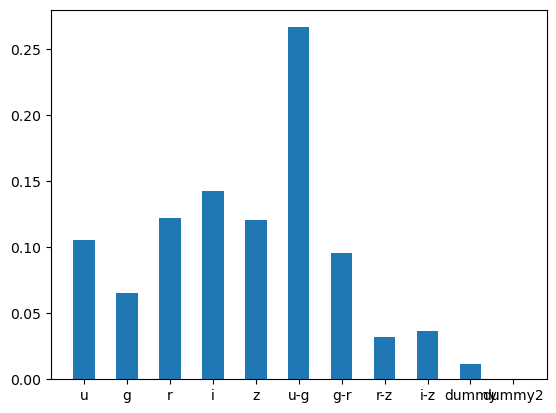

In [34]:
etc = ExtraTreesClassifier()
etc.fit(X_new,y)
plt.bar(np.arange(11), etc.feature_importances_, 0.5)
plt.xticks(np.arange(11), X_new.columns);

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_new[["dummy"]], y, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7557603686635944

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_new[["dummy2"]], y, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7557603686635944

## **Principal component analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))**

<img src="https://programmathically.com/wp-content/uploads/2021/08/pca-2-dimensions-1024x644.png" align=left width=500pt></img>

<br><br>

<img src="https://dimensionless.in/wp-content/uploads/2019/07/pca2.png" align=left width=750pt></img>

<br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
X_PCA

array([[-1.60861399,  0.89604377],
       [ 0.2947855 ,  0.48124539],
       [-6.31143191, -0.92570857],
       ...,
       [ 4.7705161 , -0.99188165],
       [ 5.33908675, -1.2158553 ],
       [ 2.31869003, -1.20122846]])

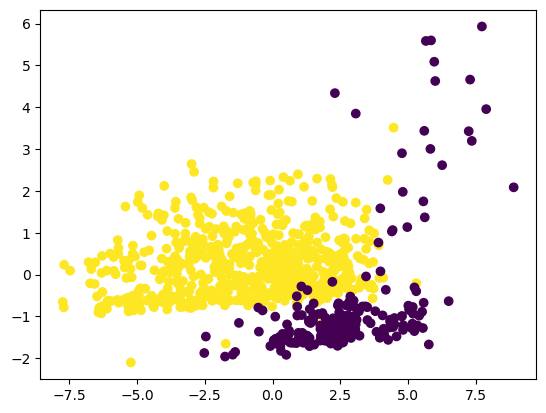

In [42]:
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y);

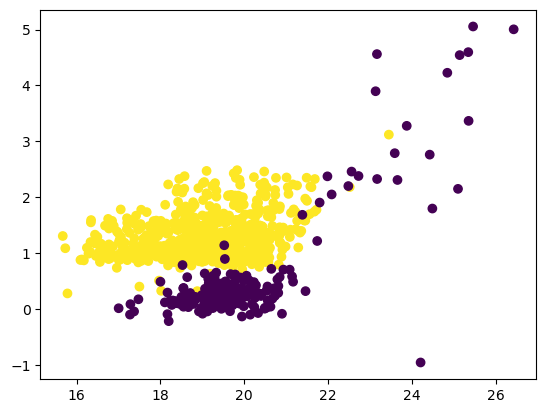

In [45]:
plt.scatter(X["u"], X["u-g"], c=y);

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.1, random_state=120, stratify=y)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9310344827586207

### task 7: **integrate `PCA()` into our pipeline**

Should scaling be performed before or after PCA?

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=120, stratify=y)

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9425287356321839

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=120, stratify=y)

model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9540229885057471

In [50]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)), ('svc', SVC(kernel='linear'))])

## **Cross-validation ([CV](https://scikit-learn.org/stable/modules/cross_validation.html))**

<img src="https://miro.medium.com/max/1400/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=800pt></img>

### task 8: **use several random states when splitting data & get average score**

In [51]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=i)

    model.fit(X_train, y_train)

    scores.append(model.score(X_test, y_test))

scores

[0.9032258064516129,
 0.9308755760368663,
 0.9354838709677419,
 0.9447004608294931,
 0.9262672811059908,
 0.9447004608294931,
 0.9078341013824884,
 0.9400921658986175,
 0.9308755760368663,
 0.9170506912442397]

In [52]:
np.mean(scores), np.std(scores)

(0.9281105990783411, 0.013855572698961217)

### task 9: **use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)**

In [60]:
from sklearn.model_selection import cross_val_score

In [63]:
scores = cross_val_score(model, X, y, cv=10)

print(scores)

[0.91954023 0.89655172 0.95402299 0.90804598 0.93103448 0.95402299
 0.96551724 0.90697674 0.94186047 0.95348837]


In [64]:
np.mean(scores), np.std(scores)

(0.9331061213579257, 0.02291918472236492)

## **Tuning hyperparameters**

In [128]:
def decision_surface(X, y, classifier):
    size = 100

    X_n = PCA(n_components=2).fit_transform(X)

    range_U = np.linspace(min(X_n[:,0]), max(X_n[:,0]), size)
    range_G = np.linspace(min(X_n[:,1]), max(X_n[:,1]), size)
    U, G = np.meshgrid(range_U, range_G)

    grid = np.vstack((U.flatten(), G.flatten())).T

    classifier.fit(X_n, y)

    predicted = classifier.predict_proba(grid)[:,0]

    predicted = predicted.reshape(size,size)

    plt.contourf(U, G, predicted, cmap="coolwarm", alpha=0.5)

    plt.plot(X_n[:,0][data.target == "star"], X_n[:,1][data.target == "star"], "o")
    plt.plot(X_n[:,0][data.target == "QSO"], X_n[:,1][data.target == "QSO"], "o");

    plt.xlabel("U [mag]")
    plt.ylabel("G [mag]");


def classify(X, y, classifier, n_components=3):
    model = make_pipeline(StandardScaler(),
                          PCA(n_components=n_components),
                          classifier)

    score = cross_val_score(model, X, y, cv=10)
    print(np.mean(score))

In [117]:
SVC?

Init signature:
SVC(
    *,
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,
)
Docstring:     
C-Support Vector Classification.

The implementation is based on libsvm. The fit time scales at least
quadratically with the number of samples and may be impractical
beyond tens of thousands of samples. For large datasets
consider using :class:`~sklearn.svm.LinearSVC` or
:class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer or
other :ref:`kernel_approximation`.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the

0.9331061213579257


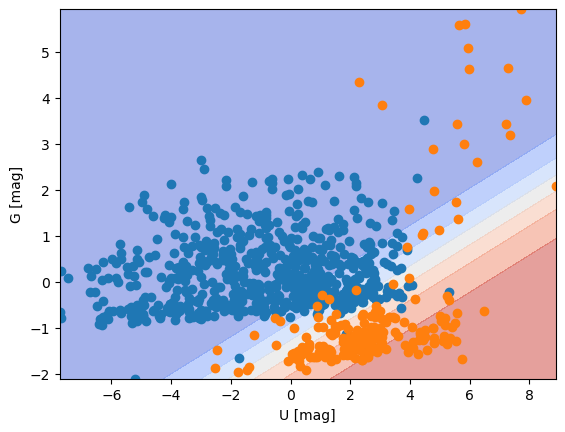

In [118]:
clf = SVC(kernel="linear", probability=True)
decision_surface(X, y, clf)
classify(X, y, clf)

0.9538225073509757


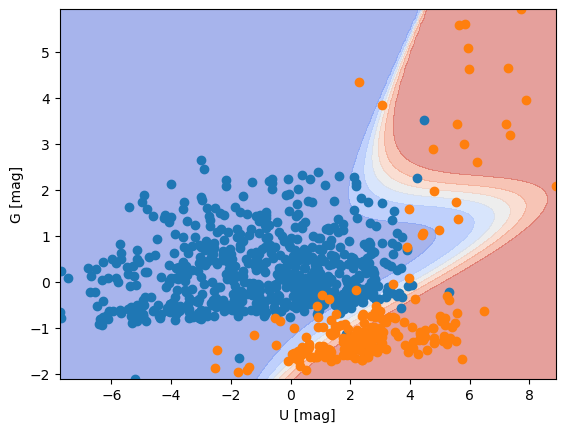

In [119]:
clf = SVC(kernel="poly", probability=True)
decision_surface(X, y, clf)
classify(X, y, clf)

0.9768912055600107


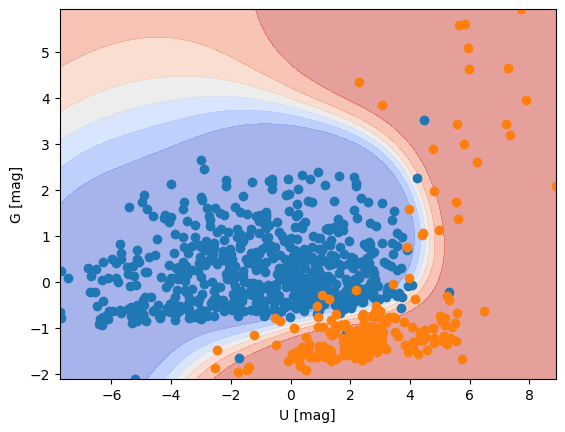

In [120]:
clf = SVC(kernel="rbf", probability=True)
decision_surface(X, y, clf)
classify(X, y, clf)

0.9618818497727881


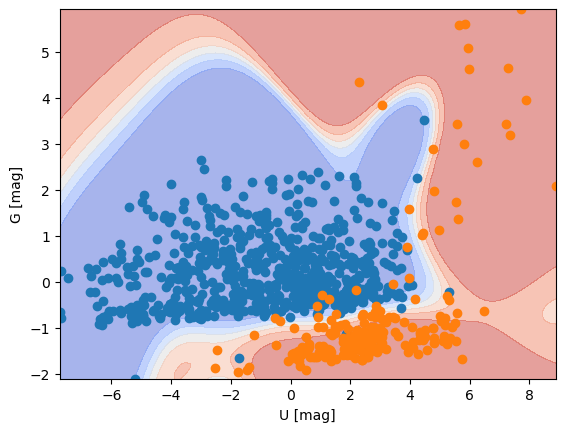

In [121]:
clf = SVC(kernel="rbf", C=1000, probability=True)
decision_surface(X, y, clf)
classify(X, y, clf)

#### task 10: **find SVC hyperparameters with best test score**

change: n_components, kernel, C

In [130]:
classify(X, y, SVC(kernel="linear"), n_components=2)

0.8639534883720931


In [131]:
classify(X, y, SVC(kernel="linear"), n_components=3)

0.9331061213579257


In [132]:
classify(X, y, SVC(kernel="linear"), n_components=4)

0.9504410585404971


In [133]:
classify(X, y, SVC(kernel="linear", C=0.1), n_components=4)

0.9469794172681102


In [138]:
classify(X, y, SVC(kernel="poly", degree=1), n_components=2)

0.8651029136594494


In [143]:
classify(X, y, SVC(kernel="poly", degree=3), n_components=3)

0.9538225073509757


In [146]:
classify(X, y, SVC(kernel="rbf"), n_components=3)

0.9768912055600107


In [150]:
classify(X, y, SVC(kernel="rbf", C=1000), n_components=3)

0.9618818497727881


### **Grid-search + crossvalidation**

In [151]:
from sklearn.model_selection import GridSearchCV

In [155]:
components = [2, 3, 4]
C = [0.01, 0.1, 1, 10, 100]

params = {"pca__n_components" : components,
          "svc__C" : C}

model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      SVC(kernel="rbf"))

gs = GridSearchCV(model, params, cv=20, n_jobs=4)
gs.fit(X, y)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=3)),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'pca__n_components': [2, 3, 4],
                         'svc__C': [0.01, 0.1, 1, 10, 100]})

In [158]:
gs.cv_results_

{'mean_fit_time': array([0.00857813, 0.00787337, 0.00785626, 0.00868034, 0.01711699,
        0.00849112, 0.00899025, 0.00525452, 0.0048457 , 0.00629834,
        0.00856583, 0.00670505, 0.00550735, 0.00529097, 0.00563675]),
 'std_fit_time': array([0.00157983, 0.00163781, 0.00198073, 0.00042925, 0.00384599,
        0.00196844, 0.00253822, 0.00061881, 0.00056896, 0.00057318,
        0.00058855, 0.00107832, 0.00158   , 0.00126586, 0.00130555]),
 'mean_score_time': array([0.00161347, 0.00147641, 0.00135422, 0.00122067, 0.00132883,
        0.001376  , 0.00170026, 0.00113368, 0.00106124, 0.00108308,
        0.00153421, 0.00133083, 0.00113209, 0.00104841, 0.00097858]),
 'std_score_time': array([0.00018593, 0.0001893 , 0.00032431, 0.00013068, 0.00029037,
        0.0003413 , 0.00040154, 0.00016237, 0.00019766, 0.0001826 ,
        0.00019594, 0.00022858, 0.00025237, 0.00022297, 0.00019432]),
 'param_pca__n_components': masked_array(data=[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
             

In [156]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=4)), ('svc', SVC(C=10))])

In [157]:
gs.best_params_

{'pca__n_components': 4, 'svc__C': 10}

In [111]:
pars, score = gs.cv_results_["params"], gs.cv_results_["mean_test_score"]

indices = np.argsort(score)

for i in indices:
    print(pars[i], score[i].round(3))

{'pca__n_components': 2, 'svc__C': 100, 'svc__gamma': 100} 0.864
{'pca__n_components': 2, 'svc__C': 100, 'svc__gamma': 10} 0.864
{'pca__n_components': 2, 'svc__C': 100, 'svc__gamma': 1} 0.864
{'pca__n_components': 2, 'svc__C': 100, 'svc__gamma': 0.1} 0.864
{'pca__n_components': 2, 'svc__C': 1, 'svc__gamma': 0.1} 0.864
{'pca__n_components': 2, 'svc__C': 1, 'svc__gamma': 1} 0.864
{'pca__n_components': 2, 'svc__C': 1, 'svc__gamma': 10} 0.864
{'pca__n_components': 2, 'svc__C': 1, 'svc__gamma': 100} 0.864
{'pca__n_components': 2, 'svc__C': 10, 'svc__gamma': 0.1} 0.864
{'pca__n_components': 2, 'svc__C': 10, 'svc__gamma': 1} 0.864
{'pca__n_components': 2, 'svc__C': 10, 'svc__gamma': 10} 0.864
{'pca__n_components': 2, 'svc__C': 10, 'svc__gamma': 100} 0.864
{'pca__n_components': 2, 'svc__C': 0.1, 'svc__gamma': 0.1} 0.866
{'pca__n_components': 2, 'svc__C': 0.1, 'svc__gamma': 1} 0.866
{'pca__n_components': 2, 'svc__C': 0.1, 'svc__gamma': 10} 0.866
{'pca__n_components': 2, 'svc__C': 0.1, 'svc__gam

In [112]:
res = gs.cv_results_

plt.figure(figsize=(len(C)*1.5,len(gamma)*1.5))
plt.imshow(res["mean_test_score"].reshape(len(C), len(gamma)), origin="lower")
n = 0
for i in range(len(C)):
    for j in range(len(gamma)):
        plt.text(j,i,"{0:.3f}".format(res["mean_test_score"][n]), ha="center")
        n += 1

plt.ylabel("C")
plt.xlabel("gamma")
plt.yticks(np.arange(len(params["C"])), params["C"]);
plt.xticks(np.arange(len(params["gamma"])), params["gamma"]);

ValueError: cannot reshape array of size 40 into shape (5,4)

<Figure size 750x600 with 0 Axes>

In [63]:
model.best_estimator_, model.best_score_

(SVC(C=10, gamma=1), 0.9838412189254211)

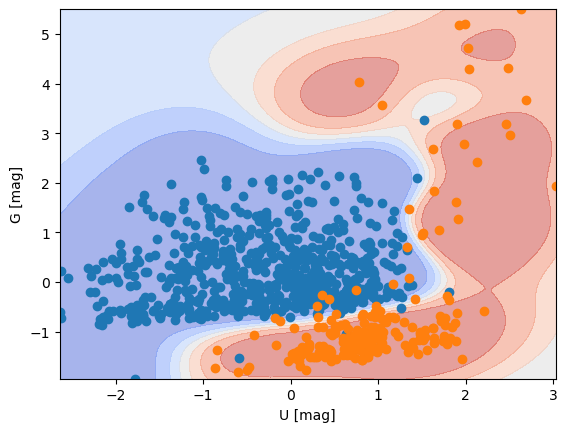

In [64]:
decision_surface(X, y, SVC(kernel="rbf", C=10, gamma=1, probability=True))

## **Classifier comparison**

In [65]:
from sklearn.neural_network import MLPClassifier # multi-layer perceptron classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [66]:
classifiers = [SVC(kernel="rbf", C=10, gamma=1),
               DecisionTreeClassifier(),
               MLPClassifier(max_iter=1000),
               GaussianNB(),
               KNeighborsClassifier()]

for classifier in classifiers:
    print(classifier)
    classify(X, y, classifier)
    print()

SVC(C=10, gamma=1)
0.9896017107725207

DecisionTreeClassifier()
0.9746458166265703

MLPClassifier(max_iter=1000)
0.9861668003207698

GaussianNB()
0.9030606789628444

KNeighborsClassifier()
0.9850307404437316



## **Ensemble methods**

### **Various hyper-parameters**

In [67]:
from sklearn.ensemble import StackingClassifier

In [68]:
classifiers = [("Linear", SVC(kernel="linear")),
               ("Quadratic", SVC(kernel="poly", degree=2))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9653702218658115, 0.015581850256831519)

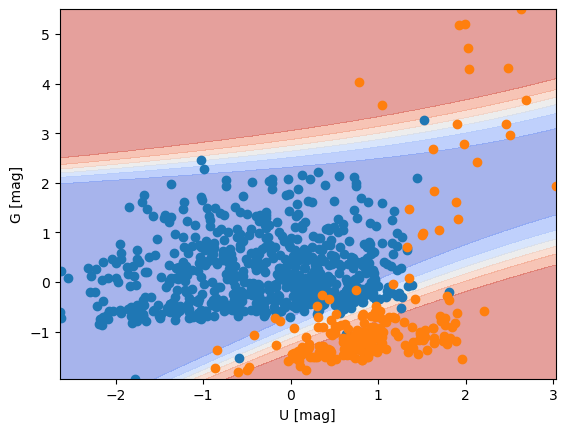

In [69]:
decision_surface(X, y, StackingClassifier(classifiers))

### **Random forest**

In [70]:
classifiers = [("One", DecisionTreeClassifier(random_state=1)),
               ("Two", DecisionTreeClassifier(random_state=2)),
               ("Three", DecisionTreeClassifier(random_state=3)),
               ("Four", DecisionTreeClassifier(random_state=4))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.973483025928896, 0.019990222032207502)

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      RandomForestClassifier(n_estimators=100))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9838679497460572, 0.013802276166860273)

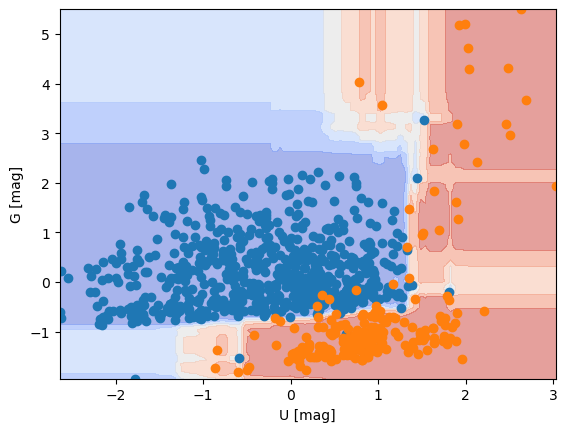

In [73]:
decision_surface(X, y, RandomForestClassifier(n_estimators=100))

### **Stacking multiple methods**

In [74]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9896284415931568, 0.006195037090662189)

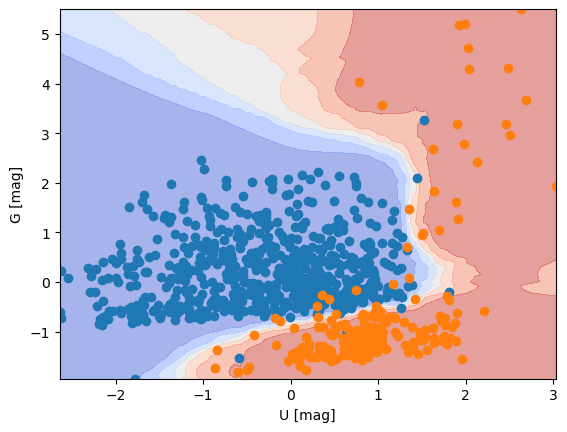

In [75]:
decision_surface(X, y, StackingClassifier(classifiers))

## **Performance evaluation**

### **[`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)**

In [76]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [77]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      StackingClassifier(classifiers))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.964     1.000     0.981        53
           1      1.000     0.988     0.994       164

    accuracy                          0.991       217
   macro avg      0.982     0.994     0.988       217
weighted avg      0.991     0.991     0.991       217



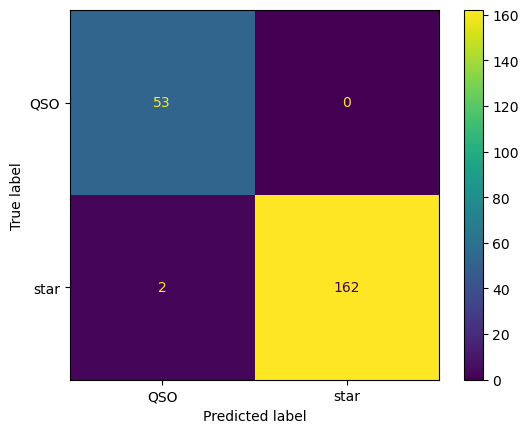

In [78]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

## **Conclusion**

0.9896284415931568 0.006195037090662189


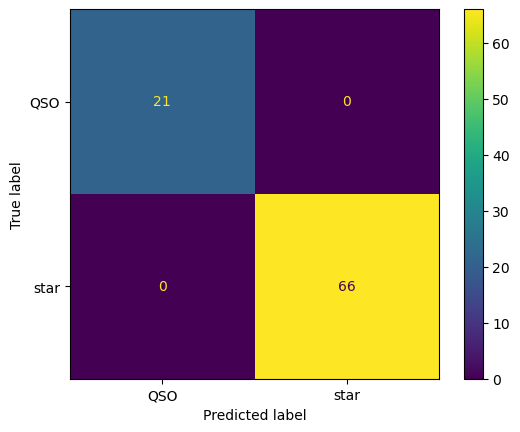

In [79]:
# Data preparation
X = data[["u","g","r","i","z"]]
le = LabelEncoder()
y = le.fit_transform(data["target"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

# Stacking classifiers
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

# Making a pipeline
model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      StackingClassifier(classifiers))

# Fitting a model for train data
model.fit(X_train, y_train)

# Testing a model on test data
score = model.score(X_test, y_test)
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

# Cross-validation
res = cross_validate(model, X, y, cv=10)
print(np.mean(res["test_score"]), np.std(res["test_score"]))

## **Model inference**

In [80]:
classifiers = [("SVC", SVC(kernel="rbf", C=10, gamma=1)),
               ("RFC", RandomForestClassifier()),
               ("MLP", MLPClassifier(max_iter=1000)),
               ("Bayes", GaussianNB()),
               ("KNN", KNeighborsClassifier())]

model = make_pipeline(StandardScaler(),
                      PCA(n_components=3),
                      StackingClassifier(classifiers))

model.fit(X, y)

Pipeline(steps=[('pca', PCA(n_components=3)),
                ('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('SVC', SVC(C=10, gamma=1)),
                                                ('RFC',
                                                 RandomForestClassifier()),
                                                ('MLP',
                                                 MLPClassifier(max_iter=1000)),
                                                ('Bayes', GaussianNB()),
                                                ('KNN',
                                                 KNeighborsClassifier())]))])

### task 11: **pick an object from SDSS and classify it**

http://skyserver.sdss.org/dr7/en/tools/search/radial.asp

In [81]:
u = 15.914
g = 15.500
r = 16.2
i = 16.5
z = 17.1

X_real = pd.DataFrame(np.array([[u,g,r,i,z]]), columns=["u","g","r","i","z"])

X_real

,u,g,r,i,z
0,15.914,15.5,16.2,16.5,17.1


In [82]:
pred = model.predict(X_real)

le.inverse_transform(pred)

array(['star'], dtype=object)

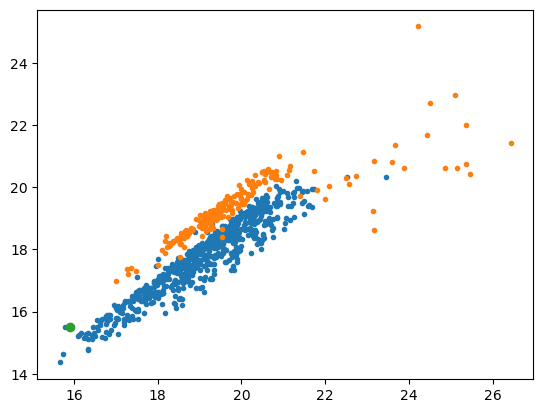

In [83]:
plt.plot(X.u[y == 1], X.g[y == 1], ".")
plt.plot(X.u[y == 0], X.g[y == 0], ".")
plt.plot(u, g, "o")